In [1]:
# import required libraries
import pandas as pd
import numpy as np
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly._subplots import make_subplots

In [2]:
# some constant variables throughout this project
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VALID_SIZE = 0.1

In [4]:
# declare dataset while importing path
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\Arfan Shah\Train',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5702 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Healthy', 'Potato___Late_blight']

In [6]:
# find length of dataset
len(dataset)

179

(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
2
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
1
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
1
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
0
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
0
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
2
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
2
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
2
(32, 256, 256, 3)
[2 1 1 0 0 2 2 2 0 2 0 1 0 0 2 0 0 2 0 2 0 1 0 2 0 0 1 0 0 2 2 0]
0


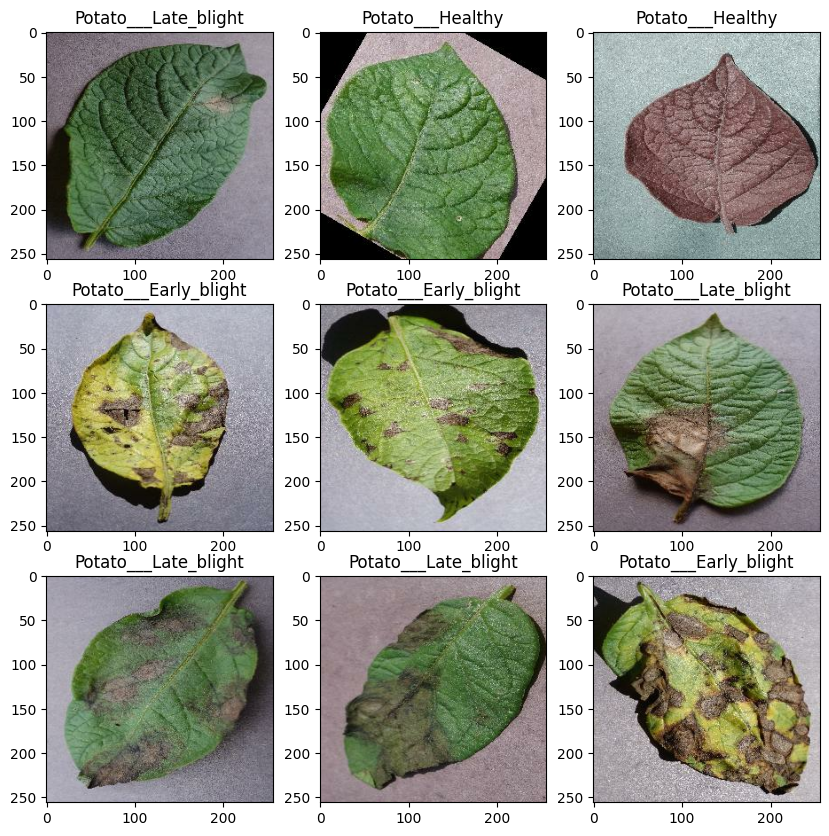

In [7]:
# lets find out images in one batch

plt.figure(figsize = (10, 10))

for image_batch, label_batch in dataset.take(1):

    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        print(image_batch.shape)
        print(label_batch.numpy())
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        print(label_batch[i].numpy())

In [8]:
# split data into training and testing
train_size = 0.8

print(len(dataset)*train_size)

# fix training dataset
train_dataset = dataset.take(144)

# test dataset
test_dataset = dataset.skip(144)

print(len(train_dataset))
print(len(test_dataset))

143.20000000000002
144
35


In [9]:
# from the training dataset we need to further split it into validation and test dataset

# declare valodation size
val_size = 0.1

print(len(dataset)*val_size)

# now set validation dataset
valid_dataset = test_dataset.take(17)

# set actual test dataset
test_dataset = test_dataset.skip(17)

print(len(valid_dataset))
print(len(test_dataset))

17.900000000000002
17
18


## Data Preprocessing

In [10]:
# now write a single function where we can split original dataset into train, test, and validation datasets
def dataset_partitions(dataset, train_size = TRAIN_SIZE, test_size = TEST_SIZE, valid_size = VALID_SIZE, shuffle = True, shuffle_size = 1000):

    # length of dataset
    dataset_size = len(dataset)

    # if statement to shuffle
    if (shuffle):
        dataset = dataset.shuffle(shuffle_size, seed = 10)

    # set train dataset
    train_size = int(dataset_size*TRAIN_SIZE)
    train_dataset = dataset.take(train_size)
    
    # set test dataset
    test_size = int(dataset_size*TEST_SIZE)
    test_dataset = dataset.skip(train_size).take(test_size)

    # set validation dataset
    valid_dataset = dataset.skip(train_size).skip(test_size)
    
    return train_dataset, test_dataset, valid_dataset

In [11]:
# now specify all dataset partitions
train_dataset, test_dataset, valid_dataset = dataset_partitions(dataset)

In [12]:
# print train, test, and validation dataset size
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

143
17
19


In [13]:
# caching and prefetching as it is improves model training
train_dataset = train_dataset.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
# now resize and rescale image dataset
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]) 

In [15]:
# data augmentation to provide multiple images for one type
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Building

In [16]:
# build model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    
    # first covolutional and pooling layer
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape, kernel_initializer = 'glorot_uniform'),
    layers.MaxPooling2D((2, 2)),

    # second convolutional and pooling layer
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'glorot_uniform'),
    layers.MaxPooling2D((2, 2)),

    # third convolutional and pooling layer
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'glorot_uniform'),
    layers.MaxPooling2D((2, 2)),

    # fourth convolutional and pooling layer
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'glorot_uniform'),
    layers.MaxPooling2D((2, 2)),

    # fifth convolutional and pooling layer
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'glorot_uniform'),
    layers.MaxPooling2D((2, 2)),

    # flatten the layer to feed to the neural network
    layers.Flatten(),

    # first dense layer
    layers.Dense(128, activation = 'tanh', kernel_initializer = 'uniform'),

    # second dense layer
    layers.Dense(128, activation = 'relu', kernel_initializer = 'uniform'),

    # third dense layer
    layers.Dense(128, activation = 'tanh', kernel_initializer = 'uniform'),

    # output layer
    layers.Dense(len(class_names), activation = 'softmax', kernel_initializer = 'uniform')
    
])

In [17]:
# now build model
model.build(input_shape = input_shape)

In [18]:
# find summary of built model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
# compile the model
model.compile(optimizer = 'adam', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

In [20]:
# fit the deep model
CNN_New_model = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = valid_dataset)

Epoch 1/10


143/143 [==============================] - 248s 2s/step - loss: 0.8984 - accuracy: 0.5409 - val_loss: 0.8766 - val_accuracy: 0.6480
Epoch 2/10
143/143 [==============================] - 226s 2s/step - loss: 0.3644 - accuracy: 0.8613 - val_loss: 0.1397 - val_accuracy: 0.9457
Epoch 3/10
143/143 [==============================] - 191s 1s/step - loss: 0.1880 - accuracy: 0.9336 - val_loss: 0.1306 - val_accuracy: 0.9457
Epoch 4/10
143/143 [==============================] - 131s 913ms/step - loss: 0.1197 - accuracy: 0.9604 - val_loss: 0.1015 - val_accuracy: 0.9622
Epoch 5/10
143/143 [==============================] - 130s 911ms/step - loss: 0.0807 - accuracy: 0.9738 - val_loss: 0.4084 - val_accuracy: 0.8668
Epoch 6/10
143/143 [==============================] - 130s 911ms/step - loss: 0.0925 - accuracy: 0.9732 - val_loss: 0.0266 - val_accuracy: 0.9934
Epoch 7/10
143/143 [==============================] - 130s 912ms/step - loss: 0.0608 - accuracy: 0.9796 - val_loss: 0.1102 - val_ac

In [22]:
CNN_New_model

In [25]:
# lets evaluate the model on test data
CNN_New_model.history

{'loss': [0.8983910083770752,
  0.3643879294395447,
  0.18804387748241425,
  0.11965161561965942,
  0.08071217685937881,
  0.09246503561735153,
  0.06083666533231735,
  0.05496060475707054,
  0.030141785740852356,
  0.055307622998952866],
 'accuracy': [0.5408791303634644,
  0.8613187074661255,
  0.9336263537406921,
  0.9604395627975464,
  0.9738461375236511,
  0.9731867909431458,
  0.9795604348182678,
  0.9821978211402893,
  0.9909890294075012,
  0.9821978211402893],
 'val_loss': [0.8765872120857239,
  0.13965989649295807,
  0.13058647513389587,
  0.10148873180150986,
  0.40840181708335876,
  0.026629580184817314,
  0.11018244922161102,
  0.030149877071380615,
  0.04993351921439171,
  0.038677722215652466],
 'val_accuracy': [0.6480262875556946,
  0.9457237124443054,
  0.9457237124443054,
  0.9621710777282715,
  0.8667762875556946,
  0.9934210777282715,
  0.9621710777282715,
  0.9901315569877625,
  0.9835526347160339,
  0.9901315569877625]}

In [28]:
# parameters
CNN_New_model.params

{'verbose': 1, 'epochs': 10, 'steps': 143}

In [29]:
# find keys
CNN_New_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
# evaluate model on test data
model.evaluate(test_dataset)

17/17 [==============================] - 7s 256ms/step - loss: 0.0364 - accuracy: 0.9908


[0.03641538321971893, 0.9908088445663452]

In [32]:
# evaluate model for training data
model.evaluate(train_dataset)

143/143 [==============================] - 36s 252ms/step - loss: 0.0381 - accuracy: 0.9875


[0.0380864255130291, 0.9874725341796875]

In [33]:
# model evlauation for validation data
model.evaluate(valid_dataset)

19/19 [==============================] - 5s 256ms/step - loss: 0.0387 - accuracy: 0.9901


[0.038677722215652466, 0.9901315569877625]

In [34]:
# find list of accuracies
CNN_New_model.history['accuracy']

[0.5408791303634644,
 0.8613187074661255,
 0.9336263537406921,
 0.9604395627975464,
 0.9738461375236511,
 0.9731867909431458,
 0.9795604348182678,
 0.9821978211402893,
 0.9909890294075012,
 0.9821978211402893]

In [35]:
CNN_New_model.history['loss']

[0.8983910083770752,
 0.3643879294395447,
 0.18804387748241425,
 0.11965161561965942,
 0.08071217685937881,
 0.09246503561735153,
 0.06083666533231735,
 0.05496060475707054,
 0.030141785740852356,
 0.055307622998952866]

In [39]:
# store all the metrics in different variables to use them to plot
accuracy = CNN_New_model.history['accuracy']
val_accuracy = CNN_New_model.history['val_accuracy']
loss = CNN_New_model.history['loss']
val_loss = CNN_New_model.history['val_loss']

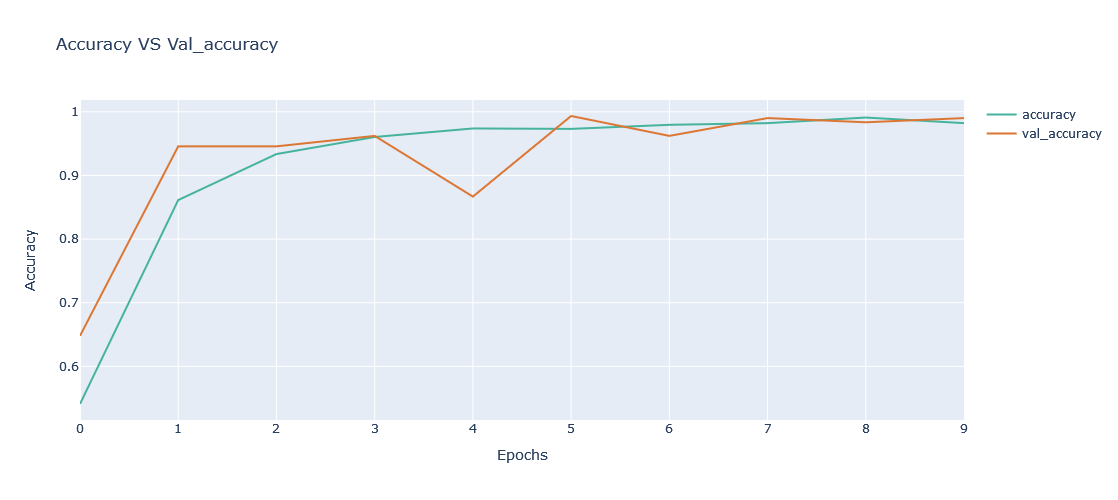

In [60]:
# plot line graph using plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x = list(range(EPOCHS)), y = accuracy, mode = 'lines', marker = dict(color = '#45b39d'), name = 'accuracy'))
fig.add_trace(go.Scatter(x = list(range(EPOCHS)), y = val_accuracy, mode = 'lines', marker = dict(color = '#dc7633'), name = 'val_accuracy'))
fig.update_layout(title = 'Accuracy VS Val_accuracy', xaxis_title = 'Epochs', yaxis_title = 'Accuracy', height = 500, width = 600)
fig.show()

In [48]:
list(range(EPOCHS))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]